In [2]:
import pickle
import pandas as pd
import requests
from bs4 import BeautifulSoup
import sys
import os
from collections import defaultdict
import re
import json
from collections import Counter
import dateutil
from dateutil import parser
from collections import defaultdict
from __future__ import division
import datetime
%pylab inline
from numpy import arange
import matplotlib.pyplot as plt

Populating the interactive namespace from numpy and matplotlib


In [3]:
def parseint(string):
    string = str(string)
    return int(''.join([x for x in string if x.isdigit()]))

In [4]:
with open('movie_info_revised.p' ,'r') as picklefile:
    data = pickle.load(picklefile)

In [5]:
def date_helper(date):
    try:
        date = parser.parse(date)
        return True
    except: 
        pass
    return False

In [6]:
history_keys_dic = defaultdict(dict)
for key in data.keys():
    if 'artificial intelligence' in data[key]['keywords']:
        if date_helper(data[key]['date']):
            year = parser.parse(data[key]['date']).year
            history_keys_dic['count'][year]= history_keys_dic['count'].get(year, 0) + 1  
history_df = pd.DataFrame.from_dict(history_keys_dic)
start = pd.datetime(1980, 1, 1)
end = pd.datetime(2016, 1, 1)
x = pd.date_range(start, end, freq='A').year
history_df_years = history_df.reindex(x)
history_df = history_df_years.fillna(0)
history_df['rolling mean']=pd.rolling_mean(history_df['count'], 5).shift(+1)
history_df['difference from mean']=history_df['count']/history_df['rolling mean']

In [7]:
history_keys_dic

defaultdict(<type 'dict'>, {'count': {1974: 1, 1975: 1, 1977: 1, 1979: 2, 1980: 1, 1982: 2, 1983: 1, 1984: 4, 1986: 3, 1990: 2, 1991: 1, 1992: 1, 1993: 1, 1995: 1, 1996: 1, 1997: 1, 1998: 1, 1999: 3, 2001: 1, 2002: 4, 2003: 4, 2004: 1, 2005: 2, 2007: 2, 2008: 3, 2009: 4, 2010: 1, 2011: 1, 2012: 1, 2013: 5, 2014: 1, 2015: 3}})

In [8]:
history_df

,count,rolling mean,difference from mean
1980,1,NaN,NaN
1981,0,NaN,NaN
1982,2,NaN,NaN
1983,1,NaN,NaN
1984,4,NaN,NaN
1985,0,1.6,0.000000
1986,3,1.4,2.142857
1987,0,2.0,0.000000
1988,0,1.6,0.000000
1989,0,1.4,0.000000


In [9]:
history_dic = defaultdict(dict)
for key in data.keys():
    if 'War' in data[key]['genre']:
        if date_helper(data[key]['date']):
            year = parser.parse(data[key]['date']).year
            history_dic[year][key]= defaultdict(dict)
            history_dic[year][key]['date']= data[key]['date']
            history_dic[year][key]['screens']= data[key]['screens']
            history_dic[year][key]['opening']= data[key]['opening']
                #space_dic['space'][year].append(key,)

In [10]:
history_dic

defaultdict(<type 'dict'>, {1973: {'Massacre in Rome': defaultdict(<type 'dict'>, {'date': '24 October 1973', 'screens': 'Error', 'opening': 'N/A'})}, 1975: {'Love and Death': defaultdict(<type 'dict'>, {'date': '10 September 1975', 'screens': 'Error', 'opening': 'N/A'}), 'The Old Gun': defaultdict(<type 'dict'>, {'date': '22 August 1975', 'screens': 'Error', 'opening': 'N/A'})}, 1976: {'Voyage of the Damned': defaultdict(<type 'dict'>, {'date': '22 December 1976', 'screens': 'n/a', 'opening': 'n/a'}), 'Seven Beauties': defaultdict(<type 'dict'>, {'date': '21 January 1976', 'screens': 'Error', 'opening': 'N/A'}), 'General Idi Amin Dada': defaultdict(<type 'dict'>, {'date': '30 August 1976', 'screens': 'Error', 'opening': 'N/A'}), 'Operation: Daybreak': defaultdict(<type 'dict'>, {'date': '27 February 1976', 'screens': 'Error', 'opening': 'N/A'})}, 1977: {'The Hiding Place': defaultdict(<type 'dict'>, {'date': '15 February 1977', 'screens': 'Error', 'opening': 'N/A'}), 'Cross of Iron': 

In [11]:
def makedf(genre):
    frames = []
    years = []
    for year, movies in genre.items():
        years.append(year)
        frames.append(pd.DataFrame.from_dict(movies, orient='index'))
    genre = pd.concat(frames, keys=years)
    genre = genre[genre.screens != 'N/A']
    genre = genre[genre.screens != 'n/a']
    genre = genre[genre.screens != 'Error']
    genre = genre[genre.opening != 'N/A']
    genre = genre[genre.screens != '']
    genre = genre[genre.opening != '']
    genre = genre[genre.opening != 'n/a']
    genre = genre[genre.opening != 'Error']
    genre['opening'] = genre['opening'].map(lambda x: parseint(x))
    genre['screens'] = genre['screens'].map(lambda x: parseint(x))
    genre['date'] = genre['date'].map(lambda x: parser.parse(x))
    genre['normalized_opening']= genre['opening']/genre['screens']
    genre = genre[genre.normalized_opening < 20000]
    return genre

In [12]:
genre=makedf(history_dic)
pd.set_option('display.max_rows', 1000)
genre1 = genre[genre.screens > 50]
genre1 = genre1.reset_index()
genre1

,level_0,level_1,date,screens,opening,normalized_opening
0,1979,1941,1979-12-14,325,2701898,8313.532308
1,1980,Private Benjamin,1980-10-10,763,4739769,6212.017038
2,1981,Stripes,1981-06-26,1074,6130197,5707.818436
3,1982,Inchon,1982-09-17,1291,2326112,1801.790860
4,1982,Monsignor,1982-10-22,857,3631834,4237.845974
5,1983,Under Fire,1983-10-21,816,1837768,2252.166667
6,1984,Best Defense,1984-07-20,1425,7872297,5524.418947
7,1984,Red Dawn,1984-08-10,1822,8230381,4517.223381
8,1984,The Razor's Edge,1984-10-19,1036,2411311,2327.520270
9,1986,Iron Eagle,1986-01-17,1080,6104754,5652.550000


In [14]:
trend = genre1[29:33]

trend

,level_0,level_1,date,screens,opening,normalized_opening
29,2002,Harrison's Flowers,2002-03-15,398,867635,2179.987437
30,2002,Hart's War,2002-02-15,2459,7771753,3160.533957
31,2002,Windtalkers,2002-06-14,2898,14520412,5010.494134
32,2003,Gods and Generals,2003-02-21,1533,4675246,3049.736464


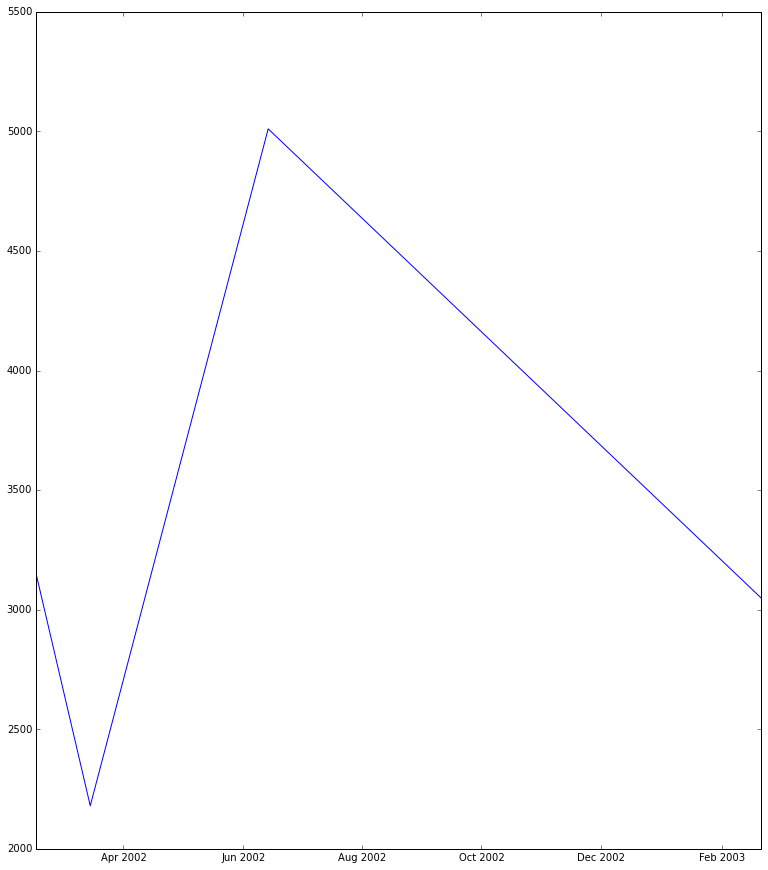

In [15]:
figure(figsize=(13,15))
trend = trend.sort(['date'])
plt.plot(trend['date'], trend['normalized_opening'])

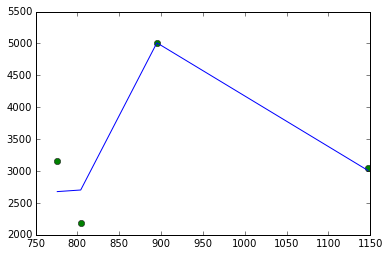

In [16]:
trend['time_delta']=trend['date'].apply(lambda x: str(x - parser.parse('2000-01-01')))
trend['time_delta_num'] = trend['time_delta'].str.replace(r'days[\s\S]+', '').apply(lambda x: int(x))

def sort_season(x):
    if x in [11, 12, 1]:
        return 'Winter'
    if x in [5, 6, 7, 8]:
        return 'Summer'
    if x in [9, 10,]:
        return 'Fall'
    if x in [2, 3, 4,]:
        return 'Spring'

trend['season']=trend['date'].apply(lambda x: sort_season(x.month))
from patsy import dmatrices
from patsy import dmatrix
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
#plot_data = trend
y, X = dmatrices('normalized_opening ~ time_delta_num + season ', data = trend, return_type= 'dataframe')
model = sm.OLS(y, X)
fitted = model.fit()
plot(X['time_delta_num'], y, 'go')
plot(X['time_delta_num'], fitted.fittedvalues, 'b')



In [33]:
model.fit().summary()

/Users/David/anaconda/lib/python2.7/site-packages/scipy/stats/stats.py:1233: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=16
  int(n))


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:     normalized_opening   R-squared:                       0.416
Model:                            OLS   Adj. R-squared:                  0.204
Method:                 Least Squares   F-statistic:                     1.962
Date:                Thu, 08 Oct 2015   Prob (F-statistic):              0.170
Time:                        19:11:19   Log-Likelihood:                -143.65
No. Observations:                  16   AIC:                             297.3
Df Residuals:                      11   BIC:                             301.2
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------------
Intercept         5702.4892   2626.483      2.171      0.053       -78.360  1.15e+04
season[T.Spring]  -782.5719   2226.047     -0.352      0.732     -5682.068  4116.925
season[T.Summer]   294.2776   2516.181      0.117      0.909     -5243.800  5832.356
season[T.Winter]  3374.5270   2062.755      1.636      0.130     -1165.567  7914.621
time_delta_num      -0.9715      0.724     -1.342      0.207        -2.565     0.622
==============================================================================
Omnibus:                        1.918   Durbin-Watson:                   1.960
Prob(Omnibus):                  0.383   Jarque-Bera (JB):                0.943
Skew:                           0.595   Prob(JB):                        0.624
Kurtosis:                       3.013   Cond. No.                     1.40e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.4e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [34]:
trend = trend.reset_index()
with open('romance.p', 'w') as picklefile:
    pickle.dump(trend, picklefile)